In [134]:
!pip install yfinance
!pip install matplotlib
!pip install numpy
!pip install backtrader

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import backtrader as bt

In [14]:
# Download stock data
ticker = 'TSLA'
stock_data = yf.download(ticker, period='10y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [17]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-02,18.366667,18.992666,18.286667,18.941334,18.941334,147786000
2014-09-03,19.177999,19.200001,18.673332,18.746000,18.746000,101584500
2014-09-04,18.934000,19.427999,18.693333,19.069332,19.069332,125125500
2014-09-05,18.836666,18.860001,18.167334,18.492666,18.492666,167548500
2014-09-08,18.507999,18.992001,18.501333,18.807333,18.807333,82524000


In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-09-02 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [19]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,106.155836,108.483262,103.674314,106.128593,106.128593,1.123747e+08
std,109.321520,111.756258,106.656686,109.228509,109.228509,7.416417e+07
min,9.488000,10.331333,9.403333,9.578000,9.578000,1.062000e+07
25%,16.697332,16.933332,16.467333,16.704000,16.704000,6.674340e+07
50%,23.589333,23.933332,23.242001,23.528667,23.528667,9.312270e+07
75%,209.500000,215.166672,204.820007,209.250000,209.250000,1.301955e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [20]:
null = stock_data.isnull().sum()
print(null)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [21]:
duplicates = stock_data.duplicated().sum()
print(duplicates)

0


In [22]:
stock_data.to_csv('stock_data.csv')

In [23]:
# Log returns
stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))

In [24]:
# Plot log returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Log Return'])
plt.title(f"{ticker} Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [40]:
# Calculate cumulative returns
stock_data['Cumulative Log Return'] = stock_data['Log Return'].cumsum()
stock_data['Cumulative Return'] = np.exp(stock_data['Cumulative Log Return']) - 1

In [41]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Cumulative Return'])
plt.title(f"{ticker} Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

In [52]:
# Download stock data
ticker = 'TSLA'
stock_data = yf.download(ticker, period='10y', interval='1d')

# Log returns
stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))

# Calculate cumulative returns
stock_data['Cumulative Log Return'] = stock_data['Log Return'].cumsum()
stock_data['Cumulative Return'] = np.exp(stock_data['Cumulative Log Return']) - 1

# Total return
total_return = stock_data['Cumulative Return'].iloc[-1]
print(f"{total_return: .2%}")

 1030.39%


In [147]:
# Rolling volatility
stock_data['Rolling Volatility'] = stock_data['Log Return'].rolling(window=20).std()

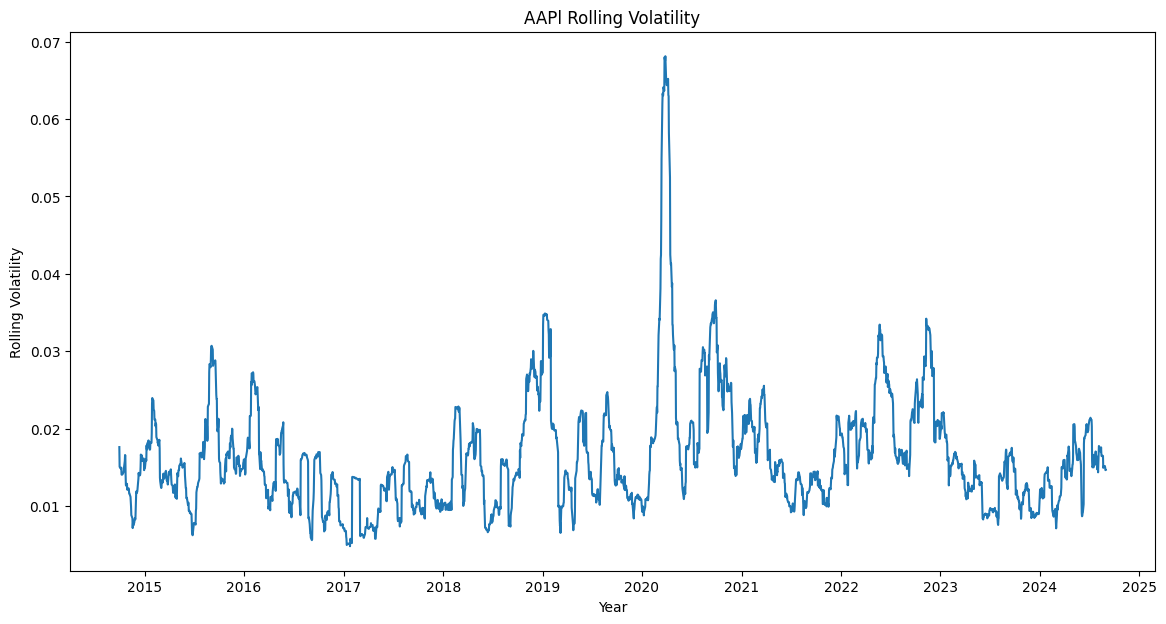

In [148]:
# Plot volatility
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Rolling Volatility'])
plt.title(f"{ticker} Rolling Volatility")
plt.xlabel("Year")
plt.ylabel("Rolling Volatility")
plt.show()

In [149]:
# Calculate 50-Day and 200-Day SMA
def calculate_sma(data, window):
    return stock_data['Adj Close'].rolling(window=window).mean()
    
stock_data['50-Day SMA'] = calculate_sma(stock_data, 50)
stock_data['200-Day SMA'] = calculate_sma(stock_data, 200)

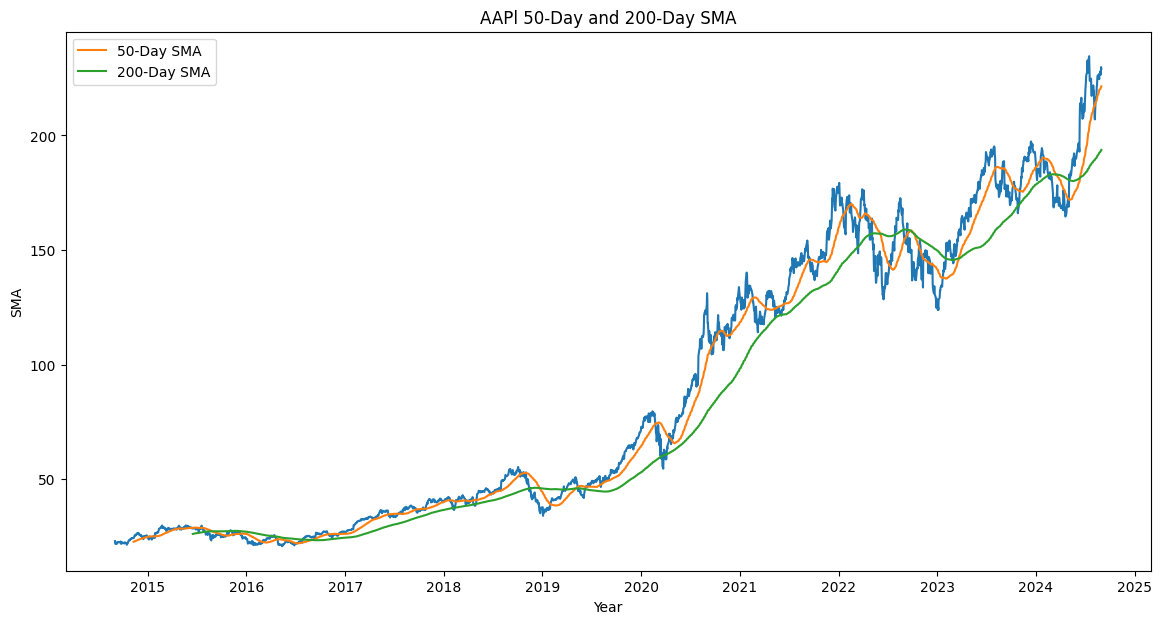

In [150]:
# Plot SMA
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'])
plt.plot(stock_data['50-Day SMA'], label="50-Day SMA")
plt.plot(stock_data['200-Day SMA'], label="200-Day SMA")
plt.title(f"{ticker} 50-Day and 200-Day SMA")
plt.xlabel("Year")
plt.ylabel("SMA")
plt.legend()
plt.show()

In [151]:
# Identifying golden crosses
golden_cross = stock_data[(stock_data['50-Day SMA'] > stock_data['200-Day SMA']) & (stock_data['50-Day SMA'].shift(1) <=stock_data['200-Day SMA'].shift(1))]

# Identifying death crosses
death_cross = stock_data[(stock_data['50-Day SMA'] < stock_data['200-Day SMA']) & (stock_data['50-Day SMA'].shift(1) >=stock_data['200-Day SMA'].shift(1))]

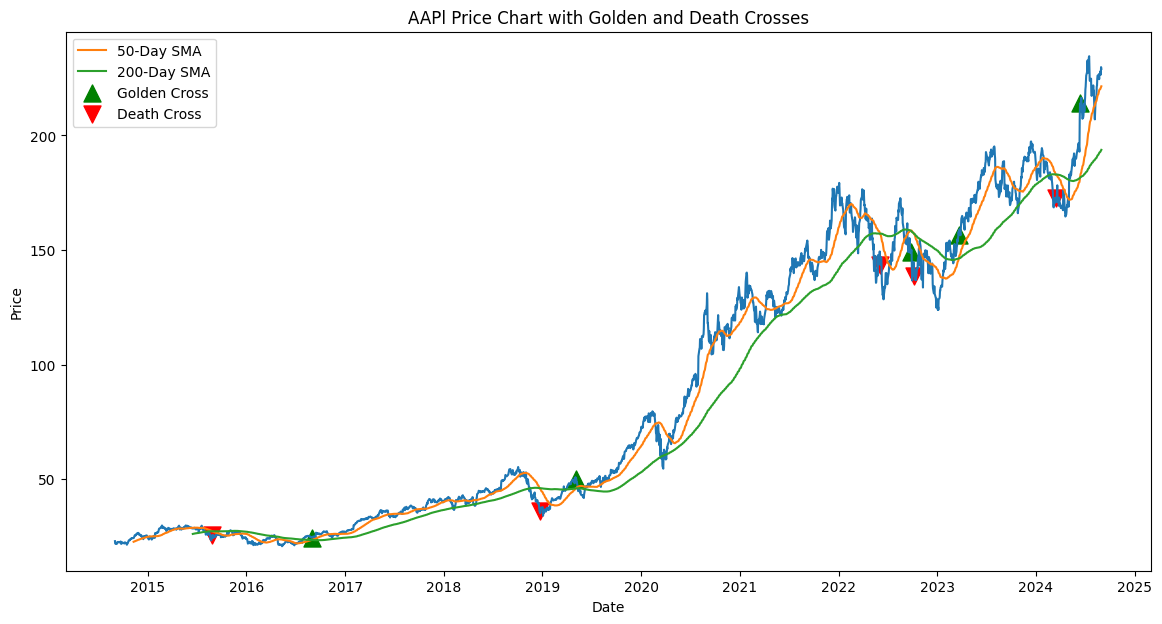

In [152]:
# Plot with markers
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'])
plt.plot(stock_data['50-Day SMA'], label="50-Day SMA")
plt.plot(stock_data['200-Day SMA'], label="200-Day SMA")

# Plot golden crosses
plt.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='^', color='green', s=150, label='Golden Cross')

# Plot death crosses
plt.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='v', color='red', s=150, label='Death Cross')

plt.title(f"{ticker} Price Chart with Golden and Death Crosses")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [153]:
# Calculate moving average convergence divergence (MACD)
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    # Calculate fast and slow EMAs
    data['12-Day EMA'] = data['Adj Close'].ewm(span=fast_period, adjust=False).mean()
    data['26-Day EMA'] = data['Adj Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate MACD line and signal line
    data['MACD Line'] = data['12-Day EMA'] - data['26-Day EMA']
    data['Signal Line'] = data['MACD Line'].ewm(span=signal_period, adjust=False).mean()
    
    # Calculate MACD histogram
    data['MACD Histogram'] = data['MACD Line'] - data['Signal Line']
    
    return data

stock_data = calculate_macd(stock_data)

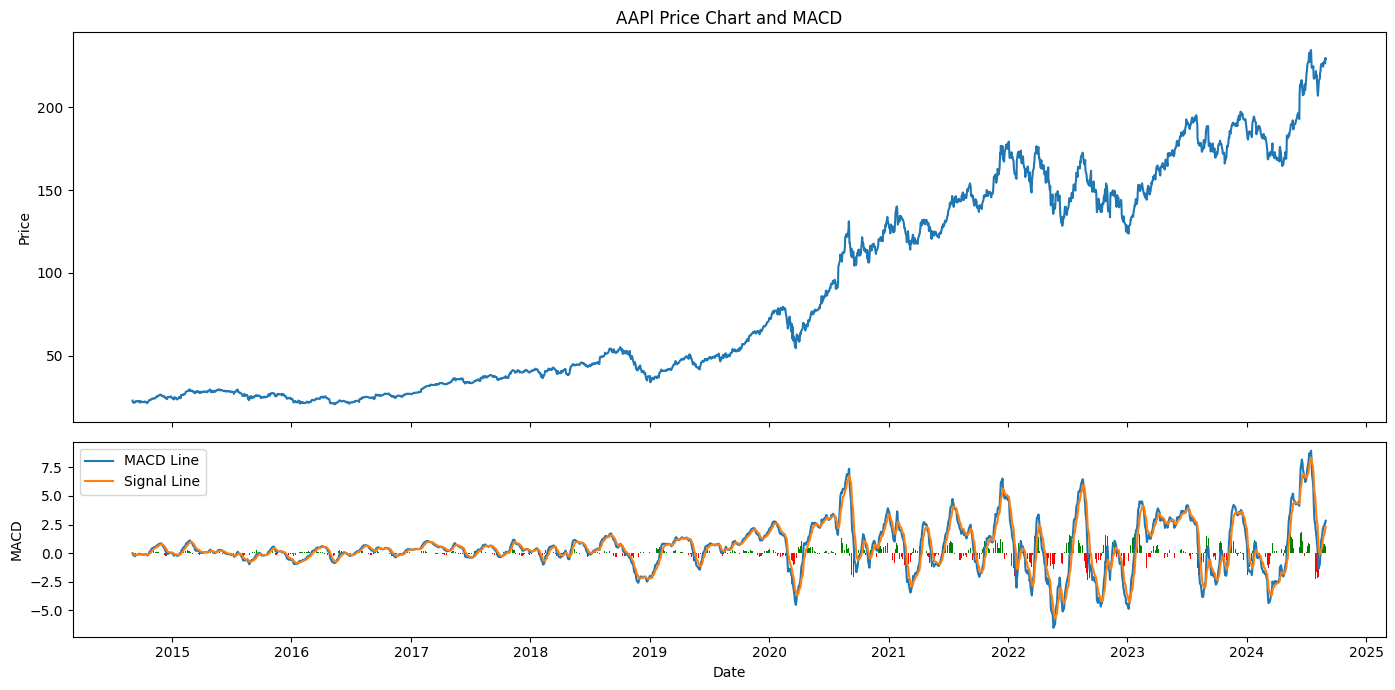

In [154]:
# Plot MACD

# Create a figure with two subplots: one for adj close price and one for MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])
ax1.set_title(f"{ticker} Price Chart and MACD")
ax1.set_ylabel("Price")

# Plot MACD on the second (smaller) subplot
ax2.plot(stock_data['MACD Line'], label='MACD Line')
ax2.plot(stock_data['Signal Line'], label='Signal Line')

# Plot MACD histogram
ax2.bar(stock_data.index, stock_data['MACD Histogram'], color=['green' if val >= 0 else 'red' for val in stock_data['MACD Histogram']])

ax2.set_xlabel("Date")
ax2.set_ylabel("MACD")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()

In [155]:
# Calculate relative strength index (RSI)
def calculate_rsi(data, window=14):
    change = data['Adj Close'].diff()
    gain = change.where(change > 0, 0)
    loss = -change.where(change < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data)

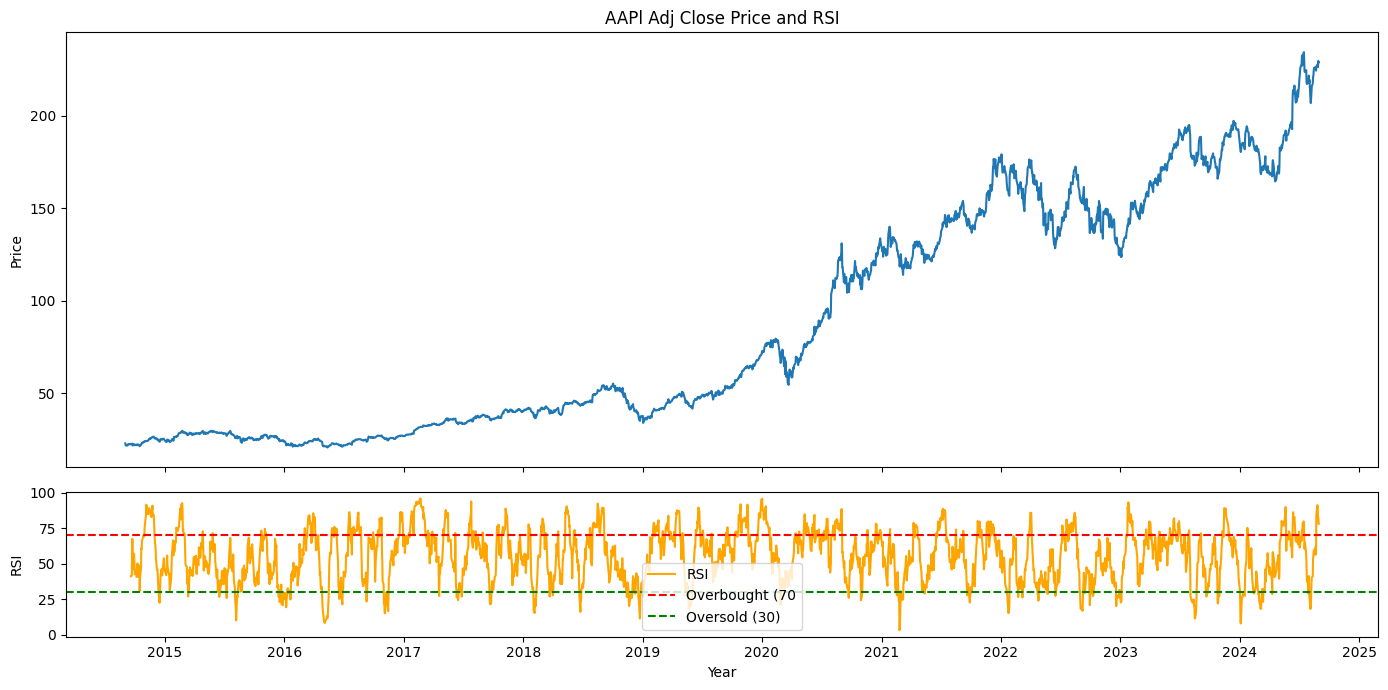

In [156]:
# Plot RSI

# Create a figure with two subplots: one for adj close price and one for RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])
ax1.set_title(f"{ticker} Adj Close Price and RSI")
ax1.set_ylabel("Price")

# Plot RSI on the second (smaller) subplot
ax2.plot(stock_data['RSI'], label="RSI", color='orange')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_xlabel("Year")
ax2.set_ylabel("RSI")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()

In [157]:
# Calculate Bollinger bands
def calculate_bollinger_bands(data, window=20):
    middle_band = data['Adj Close'].rolling(window=window).mean()
    upper_band = middle_band + 2 * data['Adj Close'].rolling(window=window).std()
    lower_band = middle_band - 2 * data['Adj Close'].rolling(window=window).std()
    
    return middle_band, upper_band, lower_band

stock_data['Middle Band'], stock_data['Upper Band'], stock_data['Lower Band'] = calculate_bollinger_bands(stock_data)

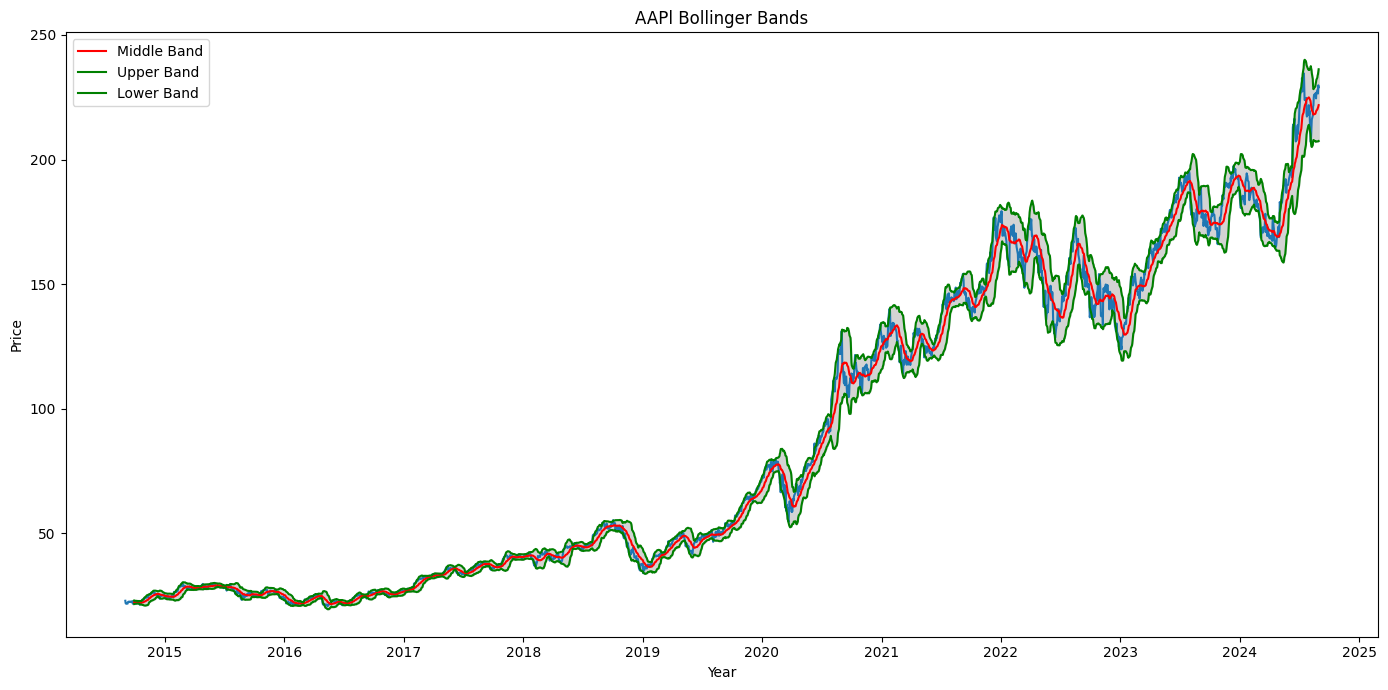

In [158]:
# Plot Bollinger bands with price
plt.figure(figsize=(14, 7))

# Plot adj close price
plt.plot(stock_data['Adj Close'])

# Plot Bollinger bands
plt.plot(stock_data['Middle Band'], label='Middle Band', color='red')
plt.plot(stock_data['Upper Band'], label='Upper Band', color='green')
plt.plot(stock_data['Lower Band'], label='Lower Band', color='green')

# Fill area between bands
plt.fill_between(stock_data.index, stock_data['Lower Band'], stock_data['Upper Band'], color='lightgray')

plt.title(f"{ticker} Bollinger Bands")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()

# Improve layout
plt.tight_layout()

plt.show()

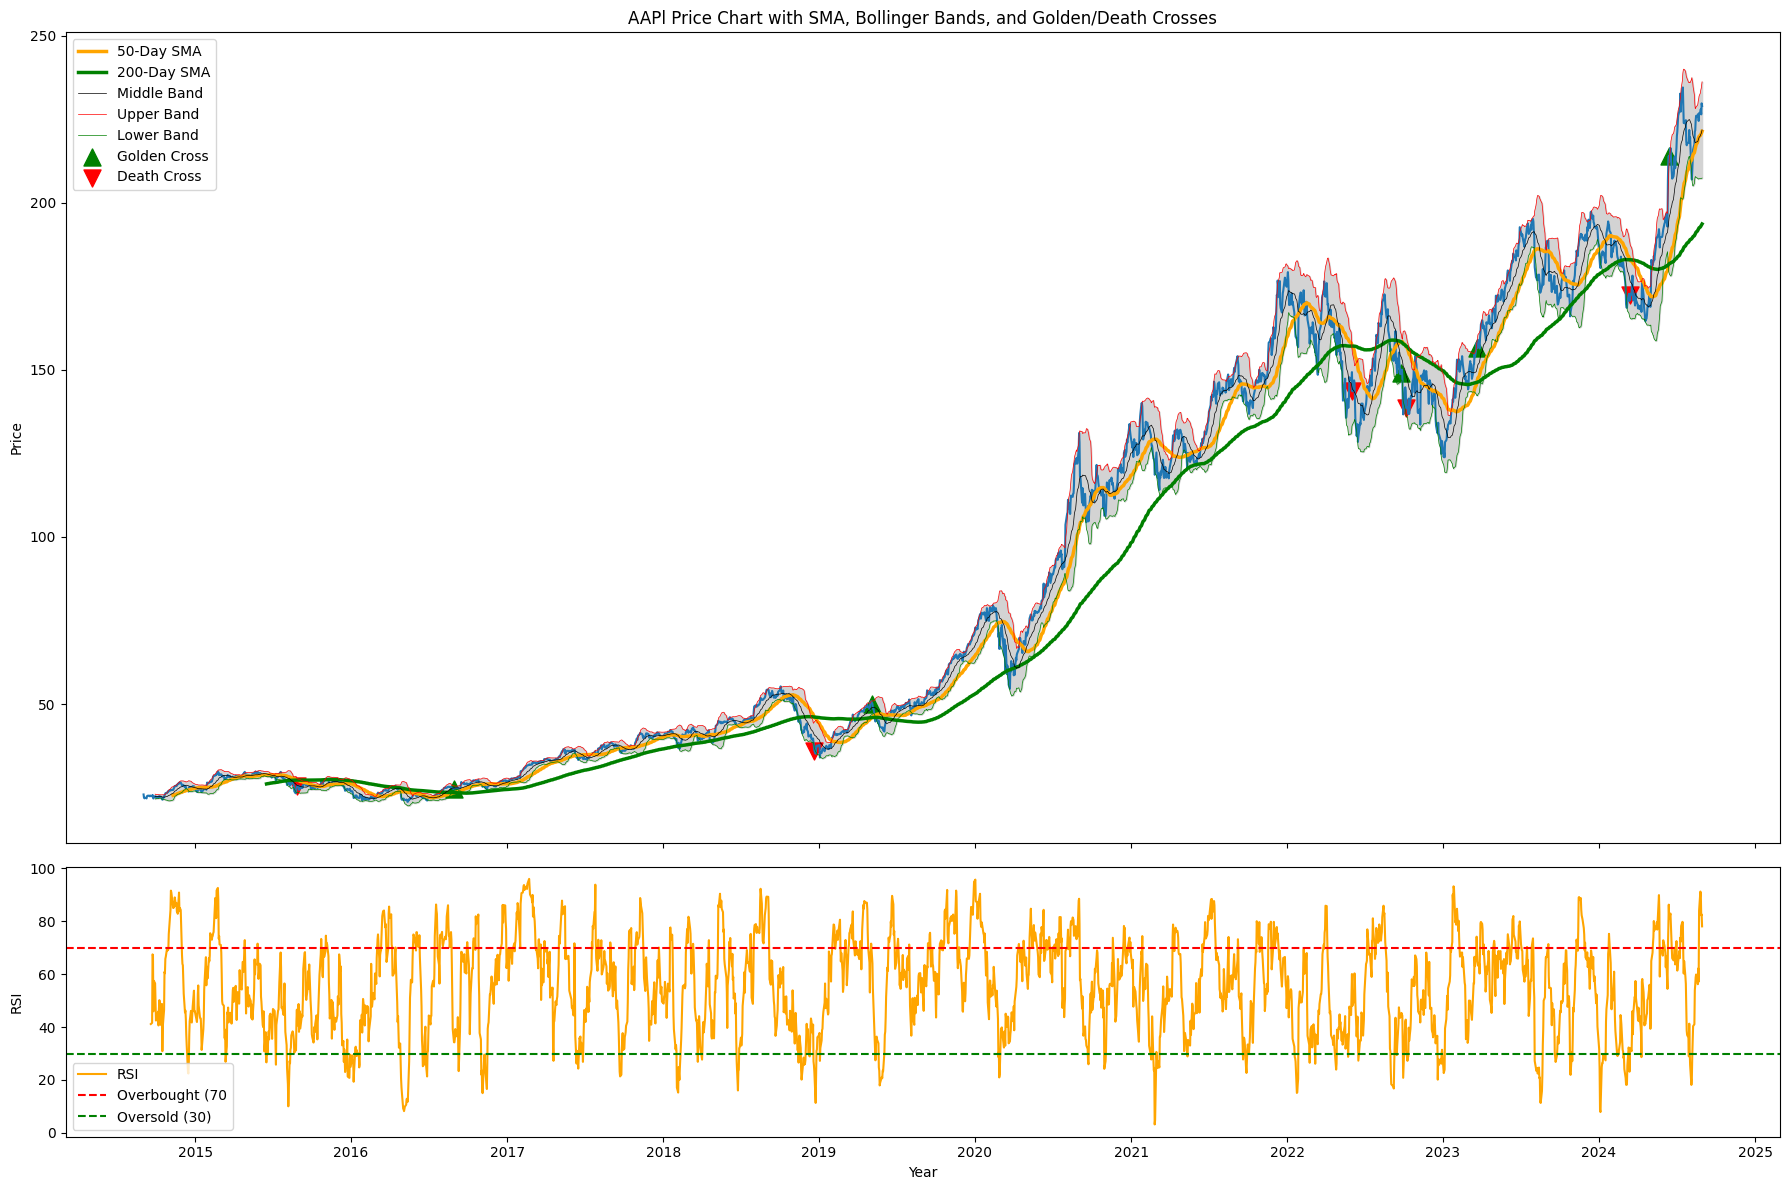

In [159]:
# Comprehensive plot: golden and death crosses, 50-Day and 200-Day SMA, Bollinger bands, and RSI

# Create a figure with two subplots: one for adj close price and moving averages, and one for RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])

# Plot the 50-Day and 200-Day SMA
ax1.plot(stock_data['50-Day SMA'], label='50-Day SMA', color='orange', lw=2.5)
ax1.plot(stock_data['200-Day SMA'], label='200-Day SMA', color='green', lw=2.5)
# Plot Bollinger bands
ax1.plot(stock_data['Middle Band'], label='Middle Band', color='black', lw=0.5)
ax1.plot(stock_data['Upper Band'], label='Upper Band', color='red', lw=0.5)
ax1.plot(stock_data['Lower Band'], label='Lower Band', color='green', lw=0.5)

# Fill area between bands
ax1.fill_between(stock_data.index, stock_data['Lower Band'], stock_data['Upper Band'], color='lightgray')

# Plot golden crosses
ax1.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='^', color='green', s=150, label='Golden Cross')

# Plot death crosses
ax1.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='v', color='red', s=150, label='Death Cross')

# Set title and labels for first subplot
ax1.set_title(f"{ticker} Price Chart with SMA, Bollinger Bands, and Golden/Death Crosses")
ax1.set_ylabel("Price")
ax1.legend()

# Plot RSI on the second (smaller) subplot
ax2.plot(stock_data['RSI'], label="RSI", color='orange')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_xlabel("Year")
ax2.set_ylabel("RSI")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()

In [162]:
# Monte Carlo simulations

# Calculate drift and volatility
drift = stock_data['Log Return'].mean() - (0.5 * stock_data['Log Return'].var())
volatility = stock_data['Log Return'].std()

# Set simulation parameters
num_simulations = 1000
num_days = 252 * 5
dt = 1 / 252

# Initialize simulation matrix
simulations = np.zeros((num_days, num_simulations))
simulations[0] = stock_data['Adj Close'].iloc[-1]

# Simulation loop
for i in range(1, num_days):
    # Generate random shocks from a standard normal distribution
    random_shocks = np.random.normal(0, 1, num_simulations)
    
    # Calculate price for the next day
    simulations[i] = simulations[i - 1] * np.exp((drift - 0.5 * volatility ** 2) * dt + volatility * random_shocks * np.sqrt(dt))

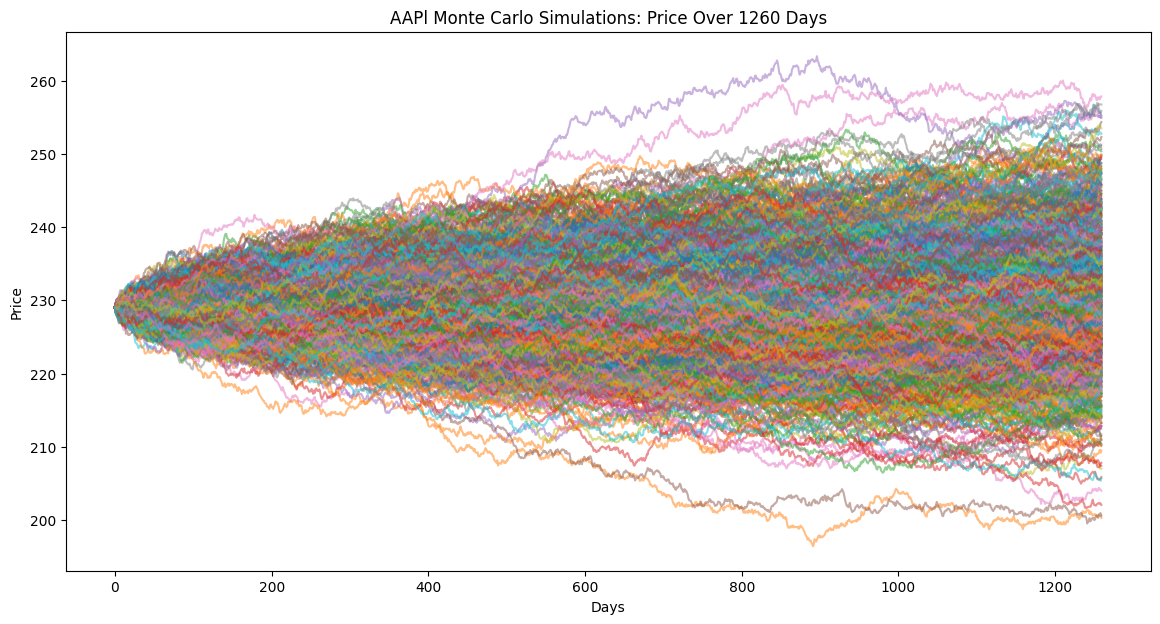

In [163]:
# Plot simulations
plt.figure(figsize=(14, 7))
plt.plot(simulations, alpha=0.5)
plt.title(f"{ticker} Monte Carlo Simulations: Price Over {num_days} Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [85]:
# Backtesting

class SmaCross(bt.Strategy):
    params = (
        ('sma_short', 50),
        ('sma_long', 200), 
    )

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_short)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_long)
        
    def next(self):
        if self.sma_short[0] > self.sma_long[0]:
            self.order = self.buy()
            
        elif self.sma_short[0] < self.sma_long[0]:
            self.order = self.sell()
    
# Initialize Cerebro engine
cerebro = bt.Cerebro()
cerebro.addstrategy(ActiveTradingStrategy)

# Add data feed
data = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(data)

# Set initial cash and broker commission
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.001)

# Run the backtest
cerebro.run()

# Plot the results
cerebro.plot(iplot=False)

[[<Figure size 1280x960 with 158 Axes>]]